In [24]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [44]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

In [45]:
train_path = 'D:/Data/HAM100000 - Harvard Dataset/preprocessed_data_15split/train'
test_path = 'D:/Data/HAM100000 - Harvard Dataset/preprocessed_data_15split/val'
batch_size = 16 

In [46]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [47]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 8464 images belonging to 7 classes.

Test Batches: 
Found 1494 images belonging to 7 classes.


In [48]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()
 

In [49]:
MainInput=Input(shape=(224, 224, 3))

Convolution Layer1

In [50]:
def convlayer1(input_value):
  conv1=Conv2D(filters=64, kernel_size=(3,3), strides=(2,2),activation="relu",padding="same")(input_value)
  conv1=BatchNormalization()(conv1)
  pool1=MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)
  return pool1

Convolution Layer2

In [51]:
def convlayer2(input_value):
  conv2=Conv2D(filters=64, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv2=BatchNormalization()(conv2)
  conv2=Conv2D(filters=64, kernel_size=(3,3),activation="relu",padding="same")(conv2)
  conv2=BatchNormalization()(conv2)

  resnet=add([input_value,conv2])
  resnet=Activation("relu")(resnet)
  return resnet

Convolution Layer3

In [52]:
def convlayer3(input_value):
  conv3=Conv2D(filters=128, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv3=BatchNormalization()(conv3)
  conv3=Conv2D(filters=128, kernel_size=(3,3),activation="relu",padding="same")(conv3)
  conv3=BatchNormalization()(conv3)


  skip=Conv2D(filters=128, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  skip=BatchNormalization()(skip)

  resnet=add([skip,conv3])
  resnet=Activation("relu")(resnet)
  return resnet

Convolution Layer4

In [53]:
def convlayer4(input_value):
  conv4=Conv2D(filters=256, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv4=BatchNormalization()(conv4)
  conv4=Conv2D(filters=256, kernel_size=(3,3),activation="relu",padding="same")(conv4)
  conv4=BatchNormalization()(conv4)


  skip=Conv2D(filters=256, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  skip=BatchNormalization()(skip)

  resnet=add([skip,conv4])
  resnet=Activation("relu")(resnet)
  return resnet

Convolution Layer5

In [54]:
def convlayer5(input_value):
  conv5=Conv2D(filters=512, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  conv5=BatchNormalization()(conv5)
  conv5=Conv2D(filters=512, kernel_size=(3,3),activation="relu",padding="same")(conv5)
  conv5=BatchNormalization()(conv5)


  skip=Conv2D(filters=512, kernel_size=(3,3),activation="relu",padding="same")(input_value)
  skip=BatchNormalization()(skip)

  resnet=add([skip,conv5])
  resnet=Activation("relu")(resnet)
  return resnet

Model Creation

Block 1

In [55]:
block1=convlayer1(MainInput)

Block 2

In [56]:
block2=convlayer2(block1)
for i in range(0,2):
  block2=convlayer2(block2)

Block 3

In [57]:
maxpool=MaxPooling2D(pool_size=(2,2), padding='same')(block2)
block3=convlayer3(maxpool)

for i in range(0,3):
  block3=convlayer3(block3)

Soft Attention Layer

In [58]:

attention_layer2,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(block3.shape[-1]),name='soft_attention')(block3)
attention_layer2=MaxPooling2D(pool_size=(2,2), padding='same')(attention_layer2)
maxpool=MaxPooling2D(pool_size=(2,2), padding='same')(block3)

concat2=concatenate([maxpool,attention_layer2])
conv = Activation("relu")(concat2)
conv= Dropout(0.5)(conv)

Block 4

In [59]:
block4=convlayer4(conv)
for i in range(0,5):
  block4=convlayer4(block4)

Block 5

In [60]:
maxpool=MaxPooling2D(pool_size=(2,2), padding='same')(block4)
block5=convlayer5(maxpool)
for i in range(0,2):
  block5=convlayer5(block5)

Output Layer

In [61]:

output = GlobalAveragePooling2D()(block5)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=MainInput, outputs=output)

In [62]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_10 (BatchN  (None, 28, 28, 128)  512        ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_12 (Conv2D)             (None, 28, 28, 128)  147584      ['activation_3[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 28, 28, 128)  147584      ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_12 (BatchN  (None, 28, 28, 128)  512        ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 batch_normalization_21 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_20 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                    (None, 14, 14, 256)  0           ['batch_normalization_21[0][0]', 
                                                                  'batch_normalization_20[0][0]'] 
                                                                                                  
 activation_8 (Activation)      (None, 14, 14, 256)  0           ['add_7[0][0]']                  
          

 batch_normalization_32 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_11 (Add)                   (None, 14, 14, 256)  0           ['batch_normalization_33[0][0]', 
                                                                  'batch_normalization_32[0][0]'] 
                                                                                                  
 activation_12 (Activation)     (None, 14, 14, 256)  0           ['add_11[0][0]']                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 256)  590080      ['activation_12[0][0]']          
                                                                                                  
 batch_nor

 ormalization)                                                                                    
                                                                                                  
 add_15 (Add)                   (None, 7, 7, 512)    0           ['batch_normalization_45[0][0]', 
                                                                  'batch_normalization_44[0][0]'] 
                                                                                                  
 activation_16 (Activation)     (None, 7, 7, 512)    0           ['add_15[0][0]']                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['activation_16[0][0]']          
 alAveragePooling2D)                                                                              
                                                                                                  
 dense (De

In [63]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [64]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = 'ResNet34+SA.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)




In [65]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=65, min_delta=0.001)
history = model.fit(train_batches,
#                     steps_per_epoch=(len(train_df)/10),
                    epochs=300,
#                     verbose=2,
                    validation_data=test_batches,
#                     validation_steps=len(test_df)/batch_size,
                    callbacks=[checkpoint,Earlystop],class_weight=class_weights)

Epoch 1/300
529/529 [==============================] - 141s 239ms/step - loss: 1.9400 - accuracy: 0.4870 - val_loss: 1.1766 - val_accuracy: 0.5047
Epoch 2/300
529/529 [==============================] - 131s 248ms/step - loss: 1.6185 - accuracy: 0.5051 - val_loss: 1.1884 - val_accuracy: 0.5957
Epoch 3/300
529/529 [==============================] - 131s 248ms/step - loss: 1.4890 - accuracy: 0.5070 - val_loss: 1.2682 - val_accuracy: 0.5127
Epoch 4/300
529/529 [==============================] - 130s 245ms/step - loss: 1.4337 - accuracy: 0.5328 - val_loss: 1.0996 - val_accuracy: 0.4973
Epoch 5/300
529/529 [==============================] - 131s 248ms/step - loss: 1.3799 - accuracy: 0.5333 - val_loss: 1.3287 - val_accuracy: 0.3876
Epoch 6/300
529/529 [==============================] - 132s 249ms/step - loss: 1.4011 - accuracy: 0.5617 - val_loss: 0.9509 - val_accuracy: 0.6493
Epoch 7/300
529/529 [==============================] - 130s 245ms/step - loss: 1.4151 - accuracy: 0.5593 - val_loss: 1

In [66]:
from tensorflow.keras import models
model.load_weights("ResNet34+SA.hdf5")

In [67]:
predictions = model.predict(test_batches, 
#                             steps=len(test_df)/batch_size, 
                            verbose=1)

94/94 [==============================] - 20s 194ms/step


In [68]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.37      0.20      0.26        49
         bcc       0.43      0.44      0.44        77
         bkl       0.46      0.29      0.35       164
          df       0.38      0.29      0.33        17
         mel       0.43      0.40      0.41       167
          nv       0.83      0.92      0.87       999
        vasc       0.85      0.52      0.65        21

    accuracy                           0.73      1494
   macro avg       0.54      0.44      0.47      1494
weighted avg       0.71      0.73      0.71      1494



In [69]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.7058120321841773
Recall: 0.7315930388219545
Accuracy: 0.7315930388219545
weighted Roc score: 0.880105227273863


In [70]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.5363169110599426
Recall: 0.4387528765205496
Accuracy: 0.7315930388219545
Macro Roc score: 0.8836348086779233


In [71]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.7315930388219545
Recall: 0.7315930388219545
Accuracy: 0.7315930388219545
Micro Roc score: 0.94398466243376


In [72]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.8838217639997176
The ROC AUC score of bcc is: 0.9204281956575534
The ROC AUC score of bkl is: 0.812997432605905
The ROC AUC score of df is: 0.8856187024572862
The ROC AUC score of mel is: 0.8416287244651616
The ROC AUC score of nv is: 0.8927381927381928
The ROC AUC score of vasc is: 0.9482106488216469


In [73]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

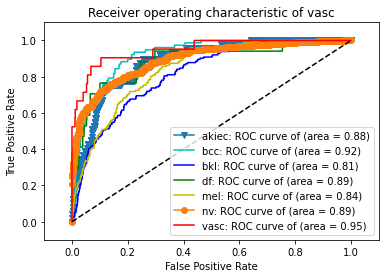

In [74]:

plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()